In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read and rename columns

In [2]:
train = pd.read_csv(r'/home/dell/Documents/medical/dataset/archive (1)/mitbih_train.csv')
test = pd.read_csv(r'/home/dell/Documents/medical/dataset/archive (1)/mitbih_test.csv')

In [3]:
train.columns

Index(['9.779411554336547852e-01', '9.264705777168273926e-01',
       '6.813725233078002930e-01', '2.450980395078659058e-01',
       '1.544117629528045654e-01', '1.911764740943908691e-01',
       '1.519607901573181152e-01', '8.578431606292724609e-02',
       '5.882352963089942932e-02', '4.901960864663124084e-02',
       ...
       '0.000000000000000000e+00.79', '0.000000000000000000e+00.80',
       '0.000000000000000000e+00.81', '0.000000000000000000e+00.82',
       '0.000000000000000000e+00.83', '0.000000000000000000e+00.84',
       '0.000000000000000000e+00.85', '0.000000000000000000e+00.86',
       '0.000000000000000000e+00.87', '0.000000000000000000e+00.88'],
      dtype='object', length=188)

In [4]:
test.columns

Index(['1.000000000000000000e+00', '7.582644820213317871e-01',
       '1.115702465176582336e-01', '0.000000000000000000e+00',
       '8.057851344347000122e-02', '7.851240038871765137e-02',
       '6.611569970846176147e-02', '4.958677664399147034e-02',
       '4.752065986394882202e-02', '3.512396663427352905e-02',
       ...
       '0.000000000000000000e+00.56', '0.000000000000000000e+00.57',
       '0.000000000000000000e+00.58', '0.000000000000000000e+00.59',
       '0.000000000000000000e+00.60', '0.000000000000000000e+00.61',
       '0.000000000000000000e+00.62', '0.000000000000000000e+00.63',
       '0.000000000000000000e+00.64', '0.000000000000000000e+00.65'],
      dtype='object', length=188)

In [5]:
new_column_names = [f"column {i}" for i in range(1, 188)] + ["label"]

train.columns = new_column_names
test.columns = new_column_names

### Data analyze


<br>In this version, the dataset is records ECG signal values at 187 time steps sampled at a frequency of 125 Hz. The duration covered by each entry is about 1.496 seconds. A full cardiac cycle lasts about 0.6 to 1 second at a normal heart rate (about 60 to 100 BPM), so a frequency of 125 Hz ensures that a full heartbeat is captured at different heart rates.
<br>The entries are divided into 5 categories:
- 0-Normal Beat
- 1-Supraventricular Premature Beat
- 2-Ventricular Premature Beat
- 3-Fusion Beat
- 4-Unknown Beat

<br>The total number of samples in this dataset is 109,446. This dataset is a processed sample of the MIT-BIH Arrhythmia Database. This database consists of over 400 long-term Holter recordings  that were obtained by the Beth Israel Hospital Arrhythmia Laboratory between 1975 and 1979. 


In [6]:
len(test)/(len(test)+len(train))

0.20002010160447353

The data is divided into 80% for train and 20% for test

Class distribution in train:
label
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


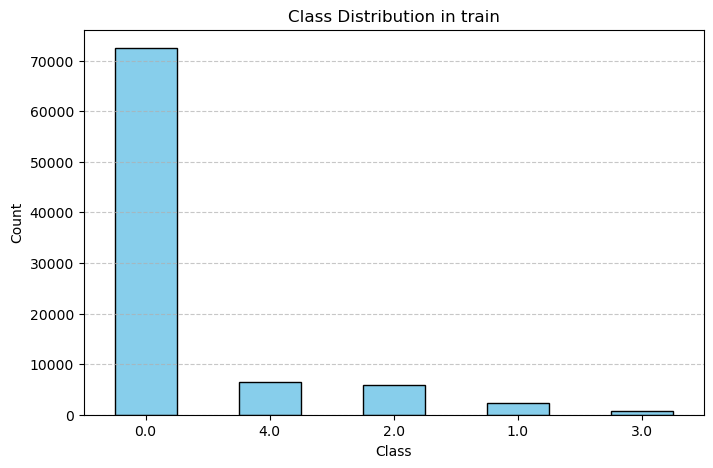

Class distribution in test:
label
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


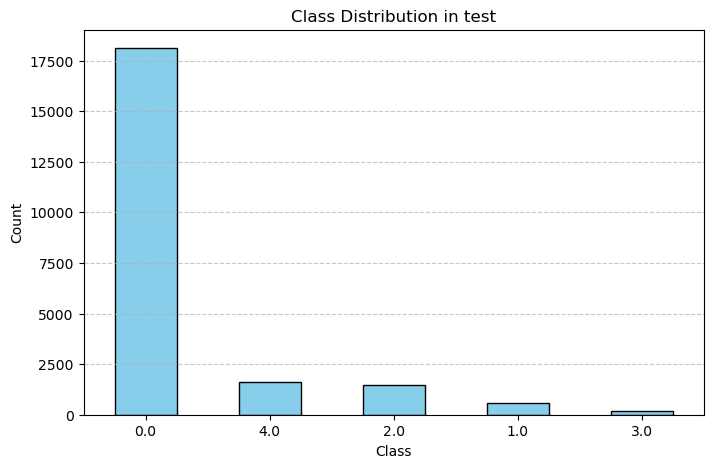

label
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

In [7]:
def count_class(data, name=None):
    import inspect

    if name is None:
        # Automatically get the variable name from the calling function
        frame = inspect.currentframe().f_back
        name = [key for key, val in frame.f_locals.items() if val is data][0]
    
    # Assuming the last column is the label column
    label_column = data.columns[-1]
    
    # Count occurrences of each class
    class_counts = data[label_column].value_counts()
    
    # Display results
    print(f"Class distribution in {name}:")
    print(class_counts)
    
    # Plot bar chart
    plt.figure(figsize=(8,5))
    class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(f"Class Distribution in {name}")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return class_counts

count_class(train)
count_class(test)

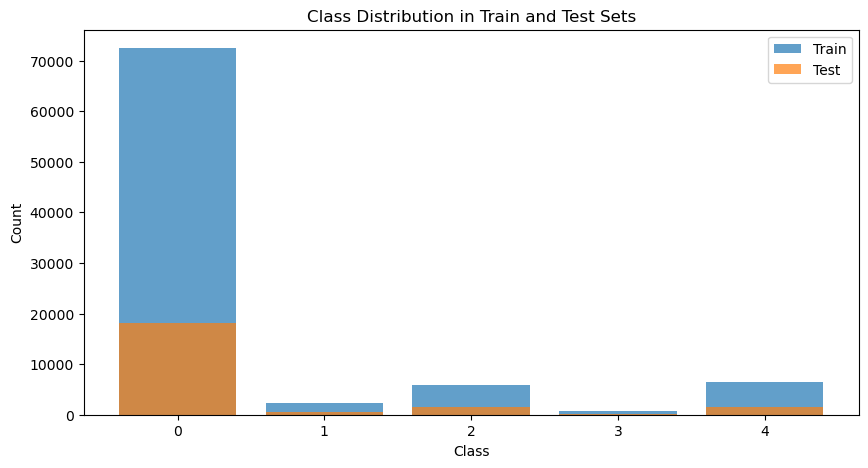

In [8]:
# Count class distribution
train_counts = train['label'].value_counts().sort_index()
test_counts = test['label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(train_counts.index, train_counts.values, alpha=0.7, label="Train")
plt.bar(test_counts.index, test_counts.values, alpha=0.7, label="Test")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in Train and Test Sets")
plt.legend()
plt.show()

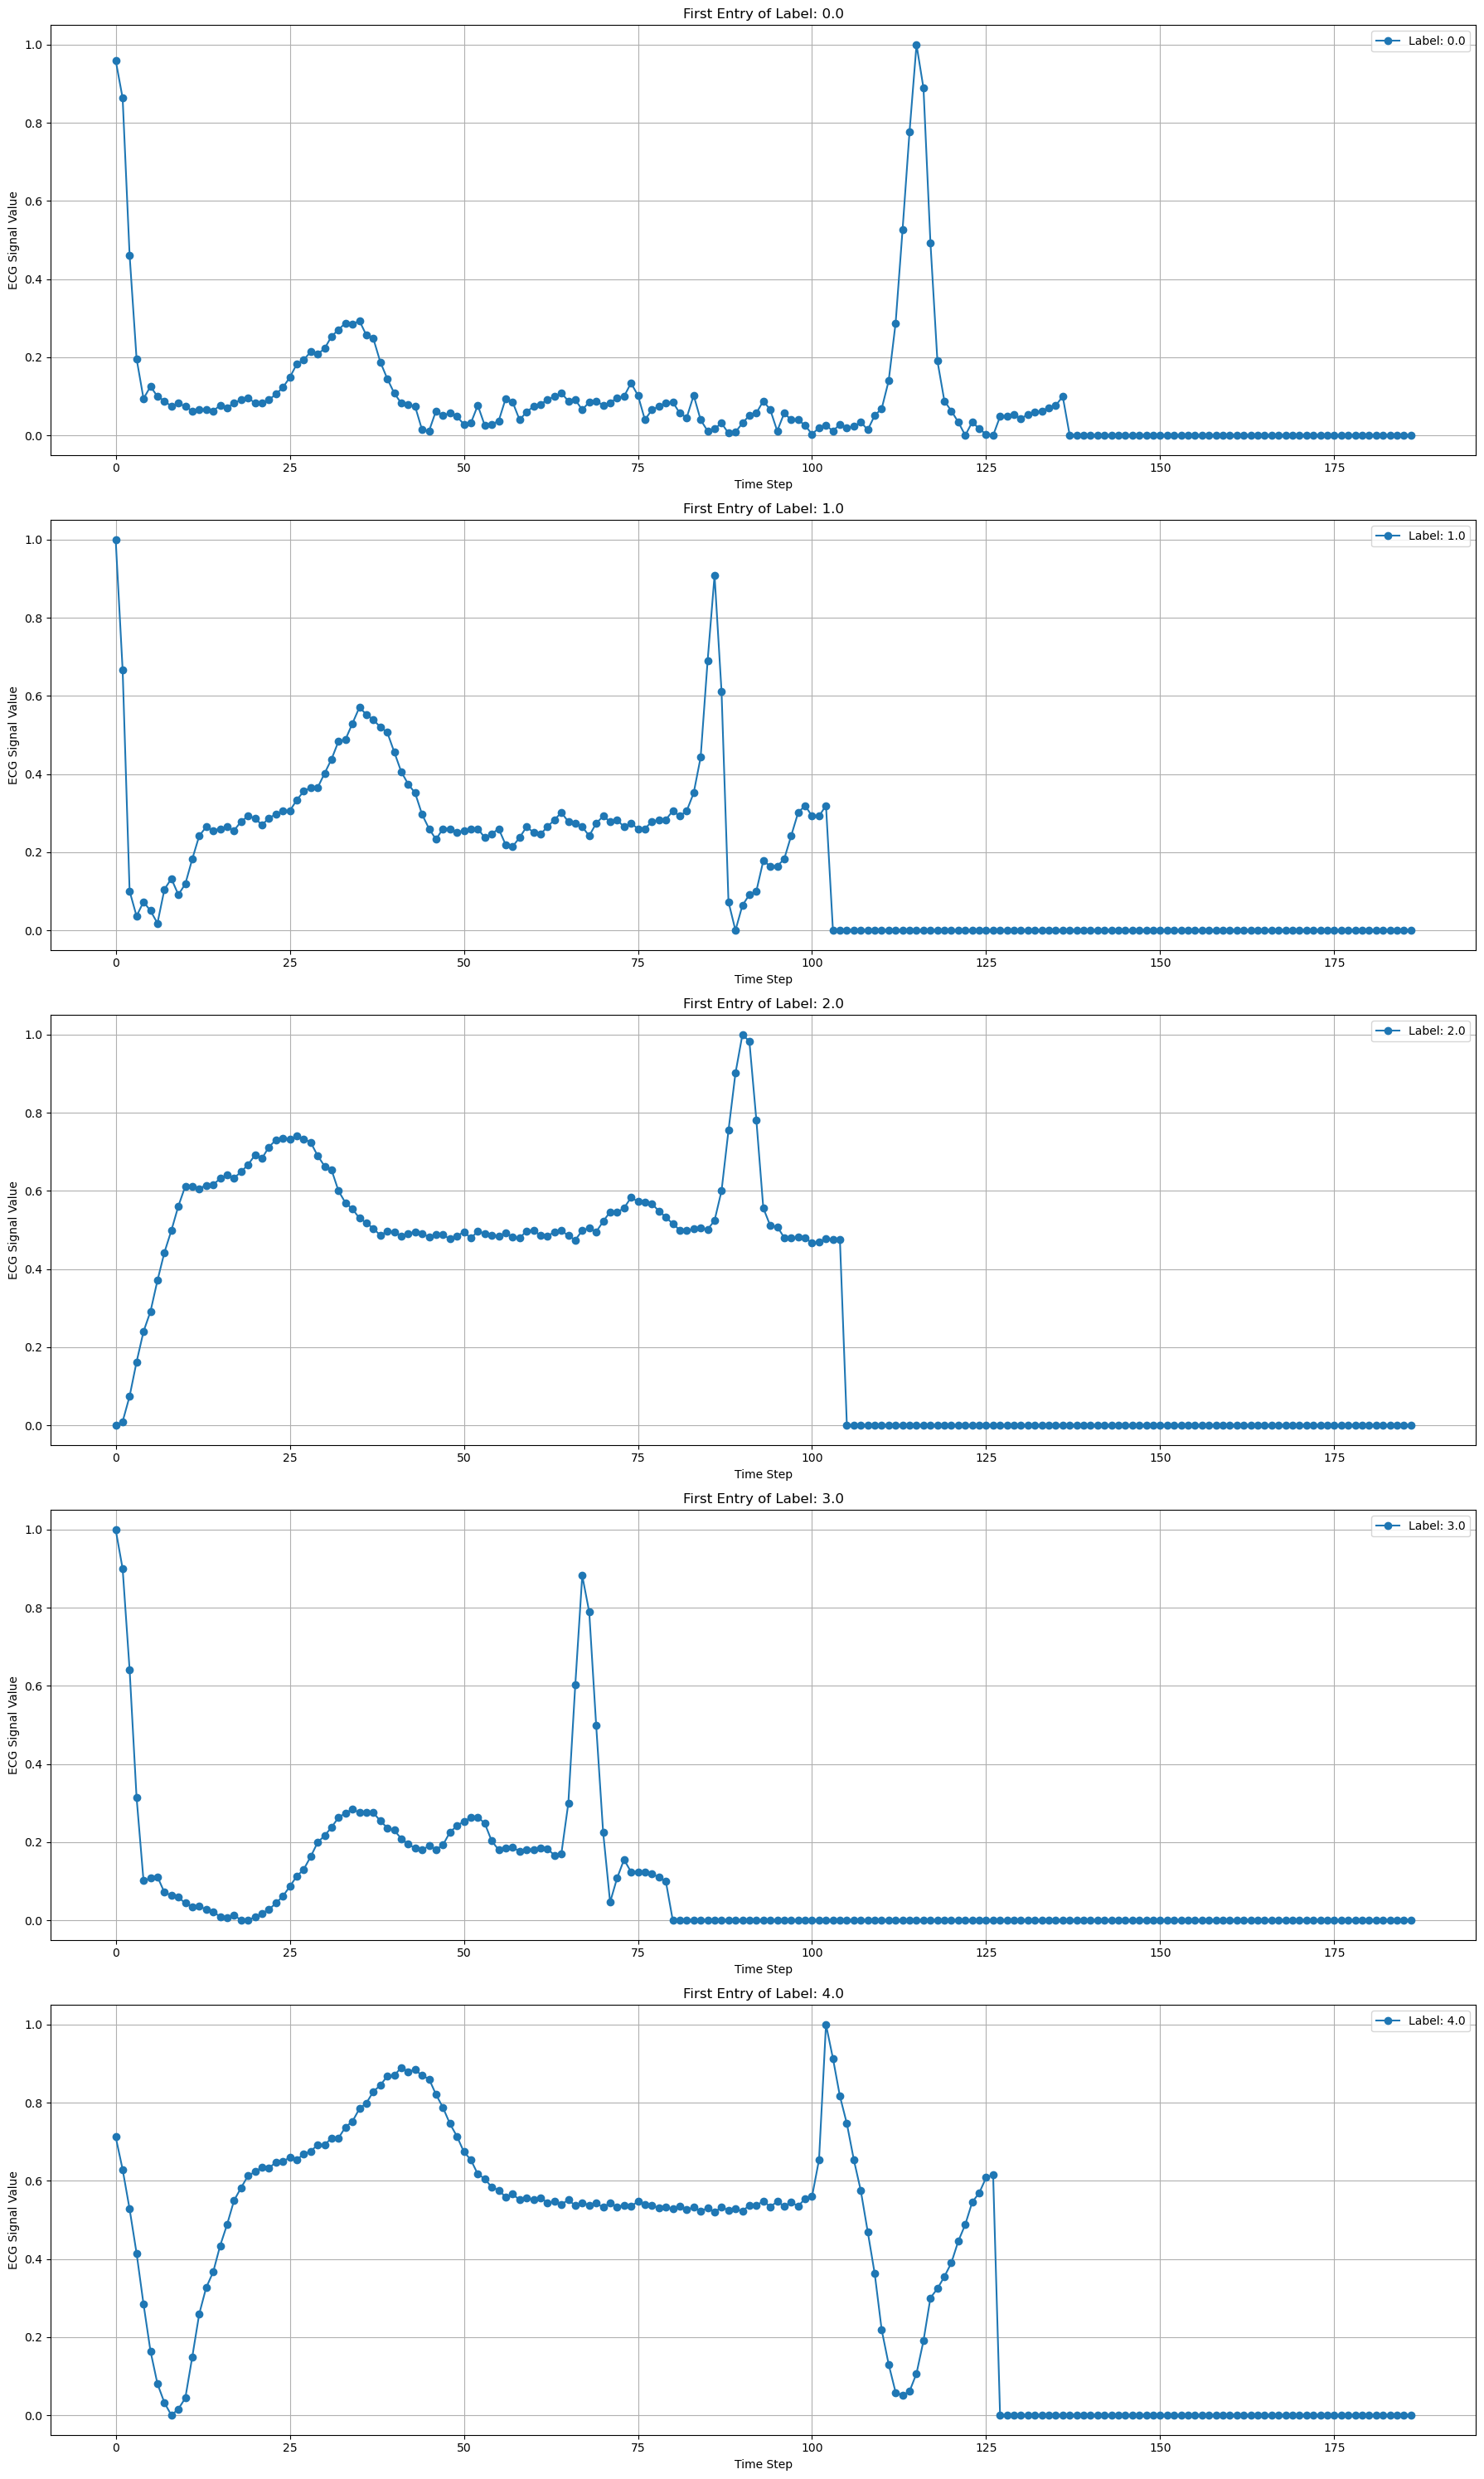

In [8]:
first_entries = train.groupby('label').first().reset_index()

# Plot
fig, axes = plt.subplots(nrows=len(first_entries), figsize=(18, 6 * len(first_entries)), tight_layout=True)

for i, row in first_entries.iterrows():
    # The ECG signal values (187 time stamps)
    values = row.values[1:]  # ECG signal values
    
    ax = axes[i] if len(first_entries) > 1 else axes  # Handle single row case
    ax.plot(values, marker='o', linestyle='-', label=f"Label: {row['label']}")
    
    # Formatting
    ax.set_title(f"First Entry of Label: {row['label']}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("ECG Signal Value")
    ax.legend()
    ax.grid()

# Show the plots
plt.show()


### Data preprocessing

In [9]:
X_train = train.iloc[:, :-1]  
y_train = train.iloc[:, -1]  
X_test = test.iloc[:, :-1]  
y_test = test.iloc[:, -1]  

How to resolve the class imbalance problem
<br> For majority class: Random Undersampling -  Tomek Links (goal: 20k samples)
<br> For minority class: Oversampling
- Class 4,2,1: SMOTE (goal: 20k sample) 
- Class 3: too little data - ADASYN (goal: 10k sample)

In [10]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

# Apply SMOTE to minority classes (Classes 4, 2, 1)
smote = SMOTE(sampling_strategy={4.0: 20000, 2.0: 20000}, random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Apply ADASYN to class 3 (since it has too few samples)
adasyn = ADASYN(sampling_strategy={3.0: 10000, 1.0: 15000}, random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_smote, y_smote)

# Apply Random Undersampling to majority class (Class 0 → 20,000)
undersampler = RandomUnderSampler(sampling_strategy={0.0: 20000}, random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_adasyn, y_adasyn)

# Apply Tomek Links to clean the data further
tomek = TomekLinks()
X_final, y_final = tomek.fit_resample(X_undersampled, y_undersampled)

# Display the new class distribution
print("New Class Distribution:", Counter(y_final))


New Class Distribution: Counter({4.0: 20000, 2.0: 19994, 0.0: 19992, 1.0: 15188, 3.0: 9970})


### Model building

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [ ]:
# Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,  # Let the trees grow as deep as needed
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

### normal sample 1: 20k

In [13]:
# y_pred = rf_model.predict(X_test)

# # Accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.4f}")

# # Classification report
# print("Classification Report:\n", classification_report(y_test, y_pred))

# # Confusion matrix
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

### New sample 1: 15k

In [14]:
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9743
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     18117
         1.0       0.99      0.60      0.74       556
         2.0       0.98      0.88      0.93      1448
         3.0       0.88      0.62      0.73       162
         4.0       1.00      0.94      0.97      1608

    accuracy                           0.97     21891
   macro avg       0.96      0.81      0.87     21891
weighted avg       0.97      0.97      0.97     21891

Confusion Matrix:
 [[18103     4     9     0     1]
 [  221   331     3     0     1]
 [  154     0  1275    14     5]
 [   47     0    14   101     0]
 [   86     0     3     0  1519]]


In [15]:
joblib.dump(rf_model, "random_forest_ecg.pkl")

['random_forest_ecg.pkl']